<a href="https://colab.research.google.com/github/ethandsz/GTSRB-Classification-Localization/blob/main/Localization%26Classification_TrafficKeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score

np.random.seed(42)

In [3]:
# Label Overview
labels = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

In [4]:
%cd gdrive/MyDrive/Traffic/

/content/gdrive/MyDrive/Traffic


In [5]:
%ls

'archive (2).zip'          Meta/
 BBox600EpochModel/        Meta.csv
 BBox600EpochModel.h5      ResNet-Traffic.pth
 cifar10-resnet9.pth       test/
 ClassificationModel.h5    Test/
 fashionmnist_model.json   Test.csv
 gfg.png                   traffic-keras.h5
 image.jpg                 _traffic-signs-in-germany_03748545_detail.jpg
 image.png                 train/
 image_test_01.jpg         Train/
 meta/                     Train.csv


In [6]:
train_path = './Train'
test_path = './Test'

IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3

In [7]:
classes = './Train'
#print(os.listdir(classes))
classes = os.listdir(classes)
classes
NUM_CATEGORIES = len(classes)

In [8]:
NUM_CATEGORIES

43

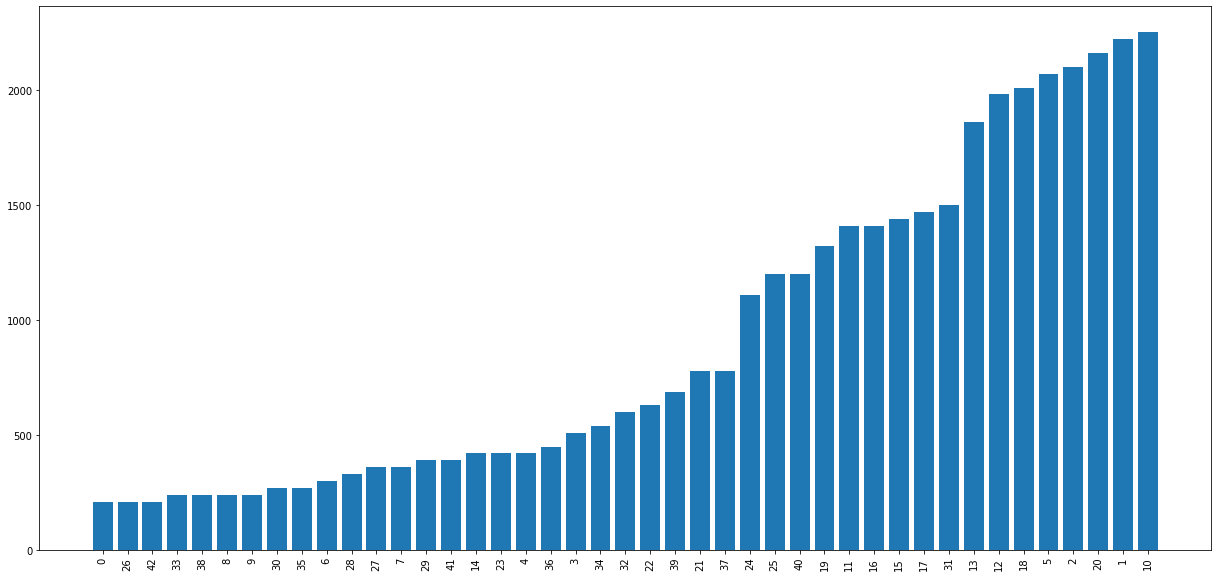

In [9]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

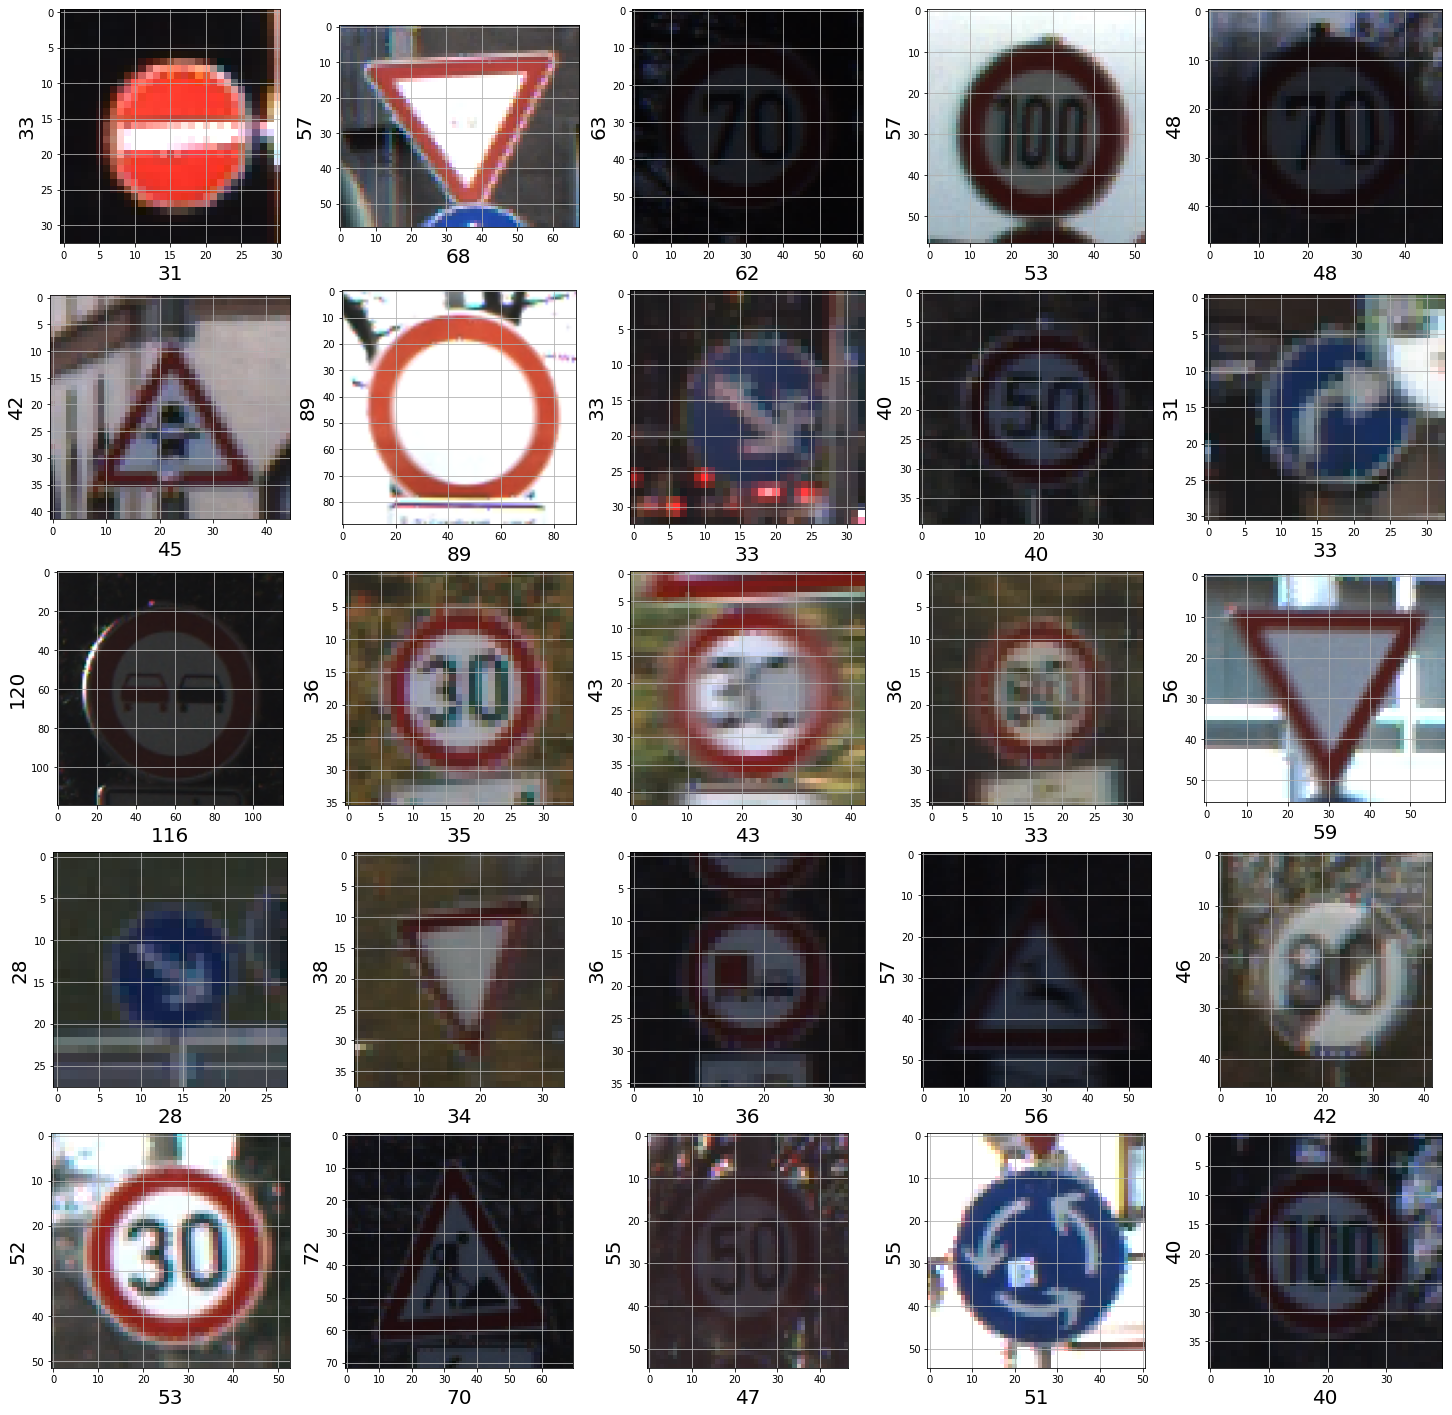

In [10]:
# Visualizing 25 random images from test data
import random
from matplotlib.image import imread

test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path ='./' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(b=None)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

Test/01283.png


<Figure size 432x432 with 0 Axes>

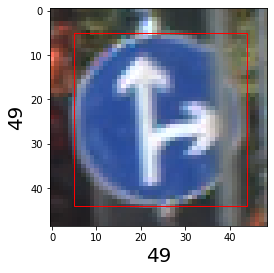

In [11]:
import random
from matplotlib.image import imread
import matplotlib.patches as patches
import matplotlib.image as mpimg



test = pd.read_csv('Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(6,6))


fig, ax = plt.subplots()

#plt.show()

random_img_path ='./' + random.choice(imgs)
rand_img = imread(random_img_path)
#rand_img = rand_img.resize((64,64))
plt.imshow(rand_img)
plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

x1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X1"].item()
x2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X2"].item()
y1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y1"].item()
y2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y2"].item()

height = test.loc[test['Path'] == random_img_path[2:]]["Height"].item()
width = test.loc[test['Path'] == random_img_path[2:]]["Width"].item()


rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

print(random_img_path[2:])

check = test.loc[test['Path'] == random_img_path[2:]]


In [12]:
import math
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

In [13]:
%%time
image_data = []
image_labels = []
image_locations = []

train = pd.read_csv('Train.csv')

for i in range(10):
    path = './Train/' + str(i)
    images = os.listdir(path)
    count = 0
    for img in images:
        try:
            image = cv2.imread(path + '/' + img)
            image_fromarray = Image.fromarray(image, 'RGB')
            resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
            image_data.append(np.array(resize_image))
            image_labels.append(i)

            img_path = path + "/" + img

            height = train.loc[train['Path'] == img_path[2:]]["Height"].item()
            width = train.loc[train['Path'] == img_path[2:]]["Width"].item()

            # x1 = train.loc[train['Path'] == img_path[2:]]["Roi.X1"].item() * (IMG_WIDTH/width)
            # x2 = train.loc[train['Path'] == img_path[2:]]["Roi.X2"].item() * (IMG_WIDTH/width)
            # y1 = train.loc[train['Path'] == img_path[2:]]["Roi.Y1"].item() * (IMG_HEIGHT/height)
            # y2 = train.loc[train['Path'] == img_path[2:]]["Roi.Y2"].item() * (IMG_HEIGHT/height)

            # x1 = sigmoid(x1)
            # x2 = sigmoid(x2)
            # y1 = sigmoid(y1)
            # y2 = sigmoid(y2)

            x1 = train.loc[train['Path'] == img_path[2:]]["Roi.X1"].item() / width
            x2 = train.loc[train['Path'] == img_path[2:]]["Roi.X2"].item() / width
            y1 = train.loc[train['Path'] == img_path[2:]]["Roi.Y1"].item() / height
            y2 = train.loc[train['Path'] == img_path[2:]]["Roi.Y2"].item() / height


            image_locations.append((x1,x2,y1,y2))
        except:
            print("Error in " + img)
        count = count + 1
        if(count == 1000):
          break
    if(i%2==0):
      print(i)

# Changing the list to numpy array
image_data = np.array(image_data)
image_labels = np.array(image_labels)
image_locations = np.array(image_locations)
print(image_data.shape, image_labels.shape)
print(img_path)

0
2
4
6
8
(8630, 32, 32, 3) (8630,)
./Train/9/00009_00046_00026.png
CPU times: user 2min 14s, sys: 2.5 s, total: 2min 16s
Wall time: 5min 31s


In [14]:
train

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


In [15]:
(image_labels == 9).any()

True

In [16]:
import math
def inverse_sigmoid(y):
  return (-math.log((1.0/y)-1.0))

Speed limit (80km/h)


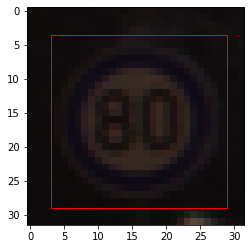

In [17]:
import random
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
i = random.randint(0,image_data.shape[0])
print(labels[image_labels[i]])
plt.imshow(image_data[i], interpolation='nearest')
# x1 = image_locations[i][0]
# x2 = image_locations[i][1]
# y1 = image_locations[i][2]
# y2 = image_locations[i][3] 

# x1 = inverse_sigmoid(x1)
# x2 = inverse_sigmoid(x2)
# y1 = inverse_sigmoid(y1)
# y2 = inverse_sigmoid(y2)

x1 = image_locations[i][0] * IMG_WIDTH
x2 = image_locations[i][1] * IMG_WIDTH
y1 = image_locations[i][2] * IMG_HEIGHT
y2 = image_locations[i][3] * IMG_HEIGHT

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()


In [18]:
image_locations.min()

0.04285714285714286

In [19]:
train_data, val_data, train_label, val_label, train_locations, val_locations = train_test_split(image_data, image_labels, image_locations, test_size=0.3, random_state=42, shuffle=True)

train_data = train_data/255 
val_data = val_data/255

print("traindata.shape", train_data.shape)
print("validdata.shape", val_data.shape)
print("trainlabel.shape", train_label.shape)
print("validlabel.shape", val_label.shape)
print("Train locations.shape ",train_locations.shape)
print("ValLocation.shape ",val_locations.shape)

traindata.shape (6041, 32, 32, 3)
validdata.shape (2589, 32, 32, 3)
trainlabel.shape (6041,)
validlabel.shape (2589,)
Train locations.shape  (6041, 4)
ValLocation.shape  (2589, 4)


In [20]:
train_label = keras.utils.to_categorical(train_label, 10)
val_label = keras.utils.to_categorical(val_label, 10)

print(train_label.shape)
print(val_label.shape)

(6041, 10)
(2589, 10)


In [21]:
train_label

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [22]:
trainTargets = {
    "bb_head": train_locations,
    "cl_head": train_label
}
validationTargets = {
    "bb_head": val_locations,
    "cl_head": val_label
}

In [23]:
len(val_locations[3])

4

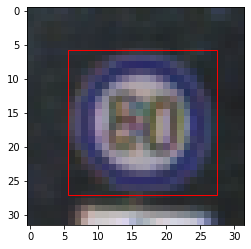

In [24]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots()
i = random.randint(0,30)
# x1 = train_locations[i][0]
# x2 = train_locations[i][1]

# y1 = train_locations[i][2]
# y2 = train_locations[i][3]

# x1 = inverse_sigmoid(x1)
# x2 = inverse_sigmoid(x2)
# y1 = inverse_sigmoid(y1)
# y2 = inverse_sigmoid(y2)

x1 = train_locations[i][0] * IMG_WIDTH
x2 = train_locations[i][1]* IMG_WIDTH

y1 = train_locations[i][2]* IMG_HEIGHT
y2 = train_locations[i][3]* IMG_HEIGHT

rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.imshow(train_data[i], interpolation='nearest')
plt.show()

In [25]:
class Sharpen(tf.keras.layers.Layer):
  """
  Sharpen layer sharpens the edges of the image.
  """
  def __init__(self, num_outputs):
    super(Sharpen, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    self.kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    self.kernel = tf.expand_dims(self.kernel, 0)
    self.kernel = tf.expand_dims(self.kernel, 0)
    self.kernel = tf.cast(self.kernel, tf.float32)

  def call(self, input_) :
    return tf.nn.conv2d(input_, self.kernel, strides=[1, 1, 1, 1], padding='SAME')

In [26]:
from keras import backend as K
K.set_image_data_format('channels_last')

In [27]:


input_shape = (IMG_HEIGHT,IMG_WIDTH,3)
input_layer = keras.layers.Input(input_shape)

##---OG---###
# base_layers = keras.layers.experimental.preprocessing.Rescaling(1./255)(input_layer)

# base_layers = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',padding='same',name='bl_1')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_2')(base_layers)
# base_layers = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same',name='bl_3')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_4')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',name='bl_5')(base_layers)

# base_layers = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same',name='bl_6')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_7')(base_layers)
# base_layers = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same',name='bl_8')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_9')(base_layers)

# base_layers = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding='same',name='bl_10')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_11')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',name='bl_12')(base_layers)

# base_layers = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same',name='bl_13')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_14')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same',name='bl_15')(base_layers)

# base_layers = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same',name='bl_16')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_17')(base_layers)
# base_layers = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same',name='bl_18')(base_layers)
# base_layers = keras.layers.BatchNormalization(axis=-1,name='bl_19')(base_layers)

# base_layers = keras.layers.MaxPool2D(pool_size=(4, 4),padding='same',name='bl_20')(base_layers)
# base_layers = keras.layers.Flatten(name='bl_21')(base_layers)
# base_layers = keras.layers.Dropout(rate=0.5,name='bl_22')(base_layers)


# classifier_branch = keras.layers.Dense(512, activation='relu',name='cl_1')(base_layers)
# classifier_branch = keras.layers.Dense(256, activation='relu',name='cl_2')(classifier_branch)
# classifier_branch = keras.layers.Dense(128, activation='relu',name='cl_3')(classifier_branch)
# classifier_branch = keras.layers.Dense(64, activation='relu',name='cl_4')(classifier_branch)
# classifier_branch = keras.layers.Dense(43, activation='softmax', name='cl_head')(classifier_branch)

# locator_branch = keras.layers.Dense(512, activation='relu',name='bb_1')(base_layers)
# locator_branch = keras.layers.Dense(256, activation='relu',name='bb_2')(locator_branch)
# locator_branch = keras.layers.Dense(128, activation='relu',name='bb_3')(locator_branch)
# locator_branch = keras.layers.Dense(64, activation='relu',name='bb_4')(locator_branch)
# locator_branch = keras.layers.Dense(32, activation='relu',name='bb_5')(locator_branch)
# locator_branch = keras.layers.Dense(4, activation='linear', name='bb_head')(locator_branch)

##--TEST---###
# base_layers = keras.layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
# base_layers = Sharpen(num_outputs=(IMG_HEIGHT, IMG_WIDTH, 3))(base_layers)
# base_layers = keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', name='bl_2')(base_layers)
# base_layers = keras.layers.Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu', name='bl_3')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2,2), name = "bl_4")(base_layers)
# base_layers = keras.layers.Dropout(rate=0.25,name='bl_5')(base_layers)
# base_layers = keras.layers.Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu', name='bl_6')(base_layers)
# #base_layers = keras.layers.MaxPool2D(pool_size=(1,1), name = "bl_7")(base_layers)
# base_layers = keras.layers.Dropout(rate=0.25,name='bl_8')(base_layers)
# base_layers = keras.layers.Flatten(name='bl_9')(base_layers)
# base_layers = keras.layers.Dense(256, activation='softmax', name='bl_10')(base_layers)
# base_layers = keras.layers.Dropout(rate=0.50,name='bl_11')(base_layers)

# #classifier_branch = keras.layers.Dense(43, activation='softmax', name='cl_head')(base_layers)

# locator_branch = keras.layers.Dense(4, activation='sigmoid', name='bb_head')(base_layers)


##TEST2###
# base_layers = keras.layers.experimental.preprocessing.Rescaling(1./255, name='bl_1')(input_layer)
# base_layers = keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu', name='bl_2')(base_layers)
# base_layers = keras.layers.Conv2D(filters=256, kernel_size=(5,5),padding='same', activation='relu', name='bl_3')(base_layers)
# base_layers = keras.layers.Conv2D(filters=256, kernel_size=(5,5), padding='same', activation='relu', name='bl_4')(base_layers)
# base_layers = keras.layers.MaxPool2D(pool_size=(2,2), name = "bl_5")(base_layers)
# base_layers = keras.layers.Dropout(rate=0.75,name='bl_6')(base_layers)

# base_layers = keras.layers.Flatten(name='bl_9')(base_layers)
# base_layers = keras.layers.Dense(128, activation='softmax', name='bl_10')(base_layers)

# locator_branch = keras.layers.Dense(4, activation='sigmoid', name='bb_head')(base_layers)


locator_branch = keras.layers.experimental.preprocessing.Rescaling(1./255, name='bb_1')(input_layer)
locator_branch = keras.layers.Conv2D(16, 3, padding='same', activation='relu', name='bb_2')(locator_branch)
locator_branch = keras.layers.MaxPooling2D(padding='same', name='bb_3', data_format="channels_last")(locator_branch)
locator_branch = keras.layers.Conv2D(32, 3, padding='same', activation='relu', name='bb_4')(locator_branch)
locator_branch = keras.layers.MaxPooling2D(padding='same', name='bb_5', data_format="channels_last")(locator_branch)
locator_branch = keras.layers.Conv2D(64, 3, padding='same', activation='relu', name='bb_6')(locator_branch)
locator_branch = keras.layers.MaxPooling2D(padding='same', name='bb_7', data_format="channels_last")(locator_branch)
locator_branch = keras.layers.Flatten(name='bb_8')(locator_branch)

locator_branch = keras.layers.Dense(128, activation='relu', name='bb_9')(locator_branch)
locator_branch = keras.layers.Dense(64, activation='relu', name='bb_10')(locator_branch)
locator_branch = keras.layers.Dense(32, activation='relu', name='bb_11')(locator_branch)
locator_branch = keras.layers.Dense(4, activation='sigmoid', name='bb_head')(locator_branch)

classifier_branch = keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),padding='same', name='cl_1')(input_layer)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_2')(classifier_branch)
classifier_branch = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same', name='cl_3')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_4')(classifier_branch)
classifier_branch = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same', name='cl_5', data_format="channels_last")(classifier_branch)

classifier_branch = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same', name='cl_6')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_7')(classifier_branch)
classifier_branch = keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same', name='cl_8')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_9')(classifier_branch)

classifier_branch = keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding='same', name='cl_10')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_11')(classifier_branch)
classifier_branch = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same', name='cl_12', data_format="channels_last")(classifier_branch)

classifier_branch = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same', name='cl_13')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_14')(classifier_branch)
classifier_branch = keras.layers.MaxPool2D(pool_size=(2, 2),padding='same', name='cl_15', data_format="channels_last")(classifier_branch)

classifier_branch = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same', name='cl_16')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_17')(classifier_branch)
classifier_branch = keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same', name='cl_18')(classifier_branch)
classifier_branch = keras.layers.BatchNormalization(axis=-1, name='cl_19')(classifier_branch)

classifier_branch = keras.layers.MaxPool2D(pool_size=(4, 4),padding='same', name='cl_20', data_format="channels_last")(classifier_branch)
classifier_branch = keras.layers.Flatten(name='cl_21')(classifier_branch)
classifier_branch = keras.layers.Dropout(rate=0.2, name='cl_22')(classifier_branch)
classifier_branch = keras.layers.Dense(512, activation='relu', name='cl_23')(classifier_branch)
classifier_branch = keras.layers.Dense(10, activation='softmax', name='cl_head')(classifier_branch)


In [28]:
model = tf.keras.Model(input_layer,
           outputs=[locator_branch, classifier_branch])

In [29]:
losses = { "bb_head":tf.keras.losses.MSE,
          "cl_head":tf.keras.losses.CategoricalCrossentropy(from_logits=True)}

In [30]:
model.compile(loss=losses, optimizer=Adam(), metrics=['accuracy'])


In [31]:
history = model.fit(train_data, trainTargets,
             validation_data=(val_data, validationTargets),
             batch_size=16,
             epochs=25,
             shuffle=True,
             verbose = 1)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


378/378 [==============================] - 20s 23ms/step - loss: 2.0702 - bb_head_loss: 0.0063 - cl_head_loss: 2.0639 - bb_head_accuracy: 0.4978 - cl_head_accuracy: 0.3082 - val_loss: 2.0577 - val_bb_head_loss: 0.0014 - val_cl_head_loss: 2.0563 - val_bb_head_accuracy: 0.4442 - val_cl_head_accuracy: 0.2673
Epoch 2/25
378/378 [==============================] - 8s 21ms/step - loss: 0.5264 - bb_head_loss: 0.0013 - cl_head_loss: 0.5250 - bb_head_accuracy: 0.4941 - cl_head_accuracy: 0.8227 - val_loss: 0.1037 - val_bb_head_loss: 0.0013 - val_cl_head_loss: 0.1024 - val_bb_head_accuracy: 0.5149 - val_cl_head_accuracy: 0.9718
Epoch 3/25
378/378 [==============================] - 8s 20ms/step - loss: 0.1267 - bb_head_loss: 0.0013 - cl_head_loss: 0.1253 - bb_head_accuracy: 0.4863 - cl_head_accuracy: 0.9593 - val_loss: 0.1595 - val_bb_head_loss: 0.0013 - val_cl_head_loss: 0.1582 - val_bb_head_accuracy: 0.4442 - val_cl_head_accuracy: 0.9506
Epoch 4/25
378/378 [==============================] - 8s 20

In [32]:
model.save("BBox600EpochModel.h5")

In [33]:
# ClassModel = keras.models.Sequential([    
#     keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(IMG_HEIGHT,IMG_WIDTH,3),padding='same'),
#     keras.layers.BatchNormalization(axis=-1),
#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),
#     keras.layers.MaxPool2D(pool_size=(2, 2),padding='same'),

#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),
#     keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),

#     keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),
#     keras.layers.MaxPool2D(pool_size=(2, 2),padding='same'),

#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),
#     keras.layers.MaxPool2D(pool_size=(2, 2),padding='same'),

#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),
#     keras.layers.Conv2D(filters=512, kernel_size=(3,3), activation='relu',padding='same'),
#     keras.layers.BatchNormalization(axis=-1),

#     keras.layers.MaxPool2D(pool_size=(4, 4),padding='same'),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(rate=0.2),
#     keras.layers.Dense(512, activation='relu'),

# #Classifier    keras.layers.Dense(43, activation='softmax'),

#     keras.layers.Dense(10, activation='softmax'),

# ])

In [34]:
# lr = 0.001
# epochs = 25

# opt = Adam(lr=lr, decay=lr / (epochs * 0.5))
# ClassModel.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [35]:
# aug = ImageDataGenerator(
#     rotation_range=10,
#     zoom_range=0.15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.15,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode="nearest")

# history = ClassModel.fit(aug.flow(train_data, train_label, batch_size=32), epochs=epochs, validation_data=(val_data, val_label))

In [36]:
# ClassModel.save("ClassificationModel.h5")

In [37]:
!--device=cpu --data_format=NHWC

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  # Remove the CWD from sys.path while we load stuff.


./Test/00691.png
[4]
5
51
5
49
Speed limit (70km/h)
[array([[0.13575104, 0.8709728 , 0.13316509, 0.87588835]], dtype=float32), array([[5.2371596e-18, 6.0857604e-12, 2.4715920e-13, 6.4811869e-16,
        1.0000000e+00, 7.6929929e-15, 4.7279018e-16, 2.8777514e-14,
        9.5414674e-12, 1.5857353e-15]], dtype=float32)]
{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedestri

<Figure size 432x432 with 0 Axes>

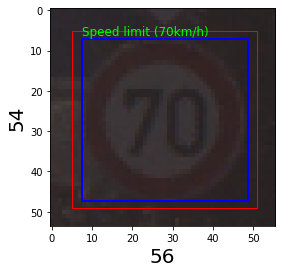

In [63]:
import random
from matplotlib.image import imread
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2


test = pd.read_csv('Test.csv')
imgs = test["Path"].values
check = test["ClassId"].between(0,9, inclusive = True)
vals = test[check]
pt = vals["Path"].sample().item()

plt.figure(figsize=(6,6))


fig, ax = plt.subplots()

#plt.show()

random_img_path ='./' + pt #random.choice(imgs)
rand_img = imread(random_img_path)
print(random_img_path)
plt.imshow(rand_img)
new_array = cv2.resize(rand_img, (IMG_WIDTH, IMG_HEIGHT))
new_array = new_array.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
pred = model.predict(new_array)
#classPred = ClassModel.predict(new_array)
print(np.argmax(pred[1],axis=1))
plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

x1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X1"].item()
x2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X2"].item()
y1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y1"].item()
y2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y2"].item()

height = test.loc[test['Path'] == random_img_path[2:]]["Height"].item()
width = test.loc[test['Path'] == random_img_path[2:]]["Width"].item()

print(x1)
print(x2)
print(y1)
print(y2)
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
classes_x=np.argmax(pred[1],axis=1)
print(labels[int(classes_x)])
print(pred)
print(labels)

# pred_x1 = (pred[0][0]) 
# pred_x2 = (pred[0][1])
# pred_y1 = (pred[0][2])
# pred_y2 = (pred[0][3]) 


pred_x1 = (pred[0][0][0]) *width
pred_x2 = (pred[0][0][1]) *width
pred_y1 = (pred[0][0][2]) *height 
pred_y2 = (pred[0][0][3]) *height

# pred_x1 = inverse_sigmoid(pred[0][0])
# pred_x2 = inverse_sigmoid(pred[0][1])
# pred_y1 = inverse_sigmoid(pred[0][2])
# pred_y2 = inverse_sigmoid(pred[0][3]) 

print(pred_x1)
print(pred_x2)
print(pred_y1)
print(pred_y2)

text = plt.text(pred_x1, pred_y1-1, labels[int(classes_x)], fontsize=12, color = 'lime')

rect = patches.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  # Remove the CWD from sys.path while we load stuff.


HI
./Test/05858.png
[5]
5
28
5
27
Speed limit (80km/h)
[array([[0.16649885, 0.84082764, 0.16834085, 0.84575266]], dtype=float32), array([[2.9340968e-12, 1.0033588e-06, 7.3611687e-08, 1.6861375e-05,
        1.1165154e-13, 9.9998212e-01, 7.5544199e-10, 7.7695290e-09,
        3.1307165e-10, 4.1784410e-12]], dtype=float32)]
{0: 'Speed limit (20km/h)', 1: 'Speed limit (30km/h)', 2: 'Speed limit (50km/h)', 3: 'Speed limit (60km/h)', 4: 'Speed limit (70km/h)', 5: 'Speed limit (80km/h)', 6: 'End of speed limit (80km/h)', 7: 'Speed limit (100km/h)', 8: 'Speed limit (120km/h)', 9: 'No passing', 10: 'No passing veh over 3.5 tons', 11: 'Right-of-way at intersection', 12: 'Priority road', 13: 'Yield', 14: 'Stop', 15: 'No vehicles', 16: 'Veh > 3.5 tons prohibited', 17: 'No entry', 18: 'General caution', 19: 'Dangerous curve left', 20: 'Dangerous curve right', 21: 'Double curve', 22: 'Bumpy road', 23: 'Slippery road', 24: 'Road narrows on the right', 25: 'Road work', 26: 'Traffic signals', 27: 'Pedes

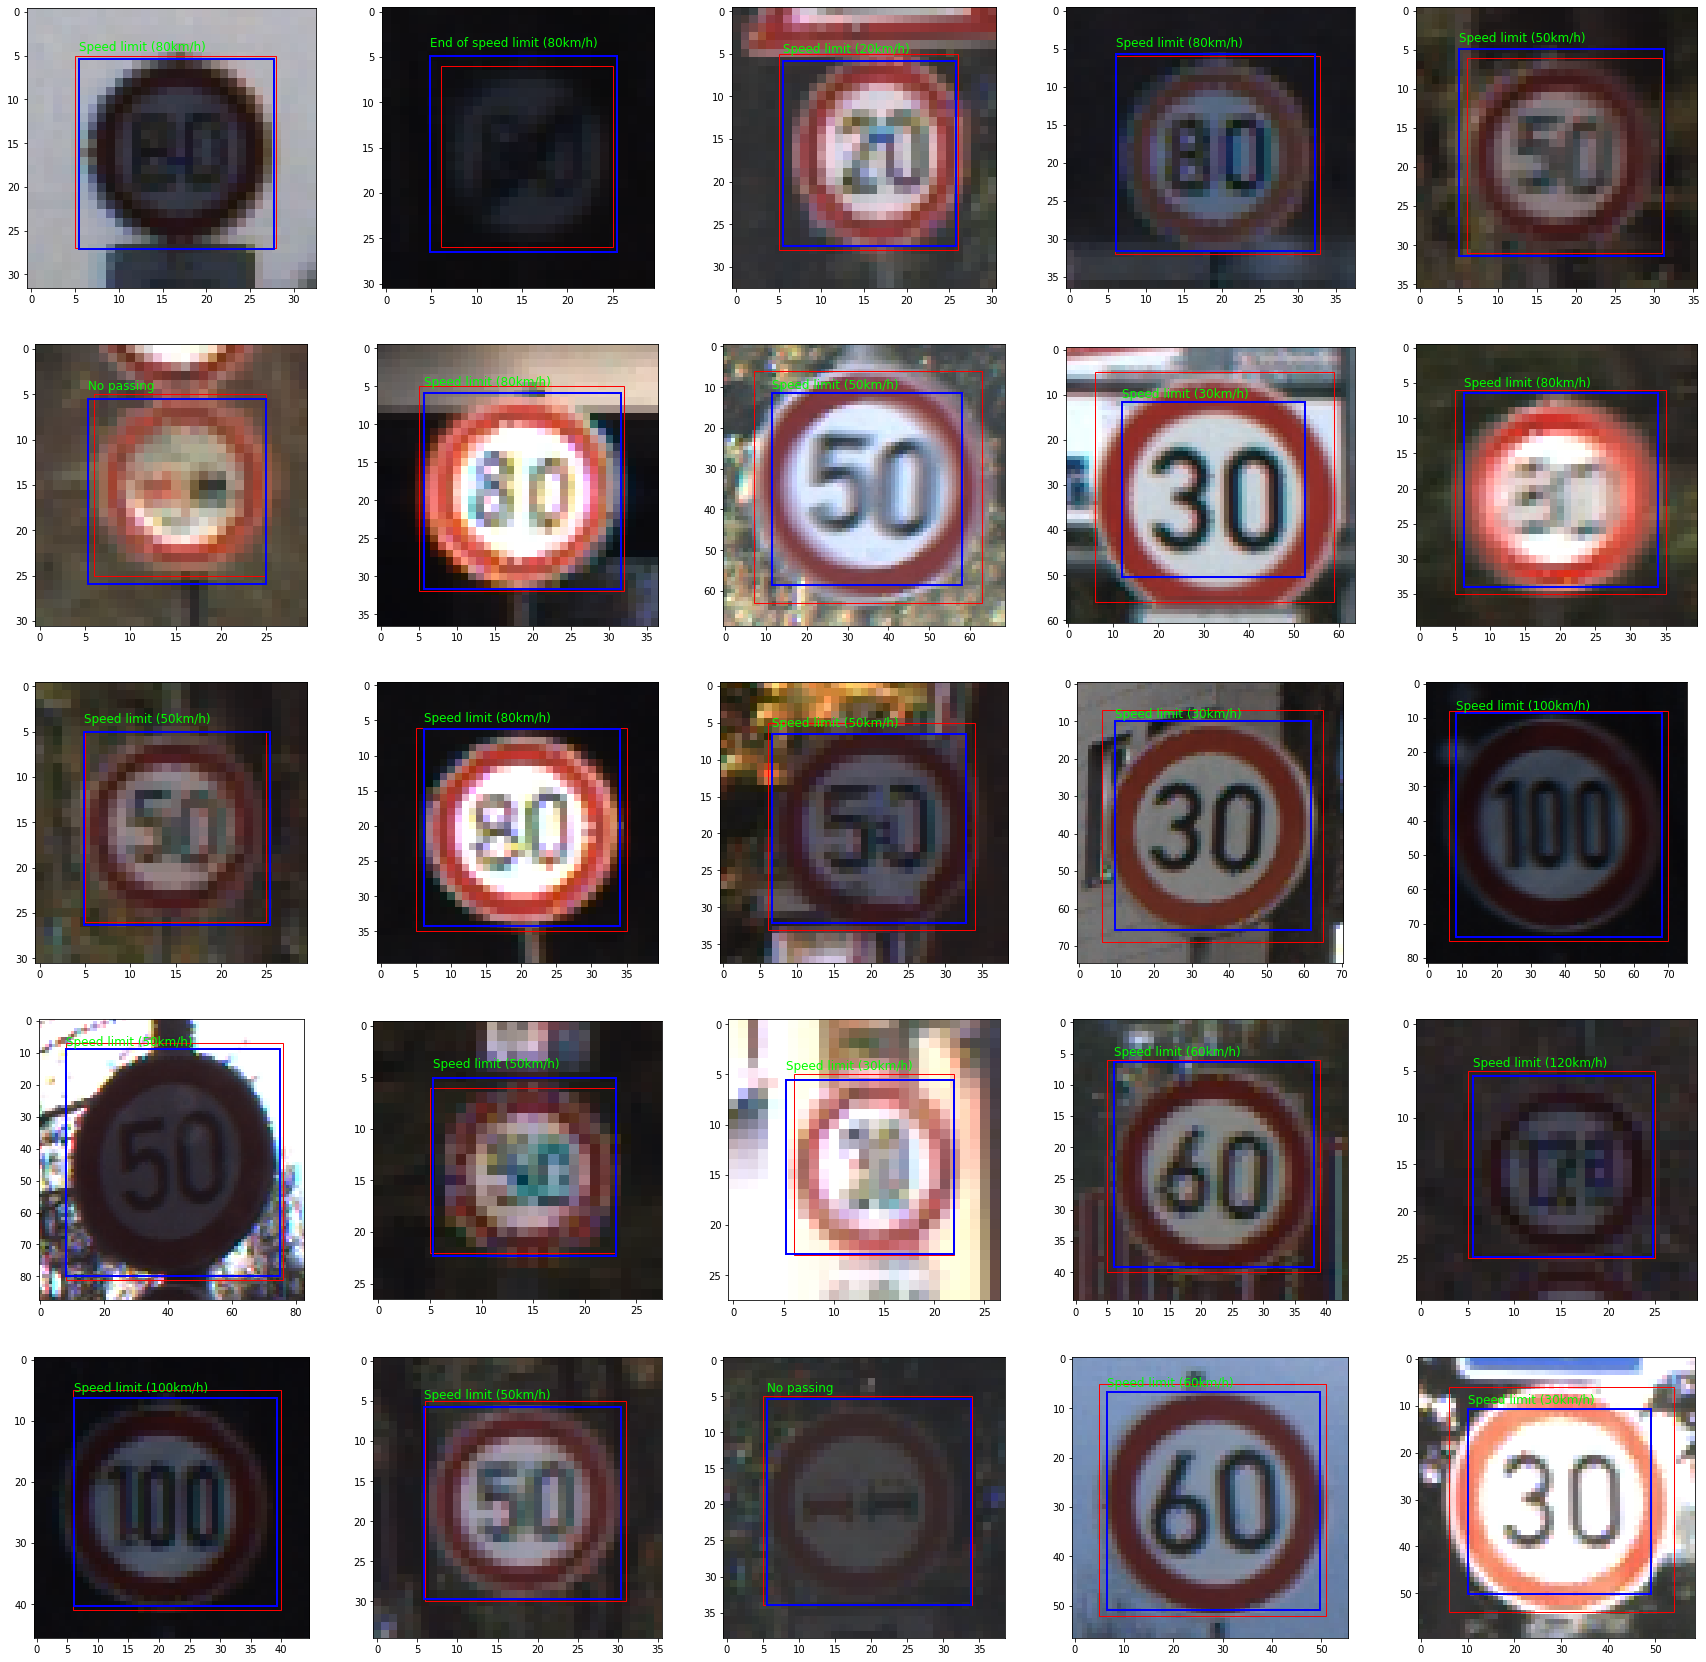

In [94]:
import random
from matplotlib.image import imread
import matplotlib.patches as patches
import matplotlib.image as mpimg
import cv2


test = pd.read_csv('Test.csv')
imgs = test["Path"].values
check = test["ClassId"].between(0,9, inclusive = True)
vals = test[check]
pt = vals["Path"].sample().item()
fig = plt.figure
fig = plt.figure(figsize=(30,30))


#fig, ax = plt.subplots()

#plt.show()
for i in range(1,26):
  pt = vals["Path"].sample().item()
  print("HI")
  ax = fig.add_subplot(5,5, i)
  random_img_path ='./' + pt #random.choice(imgs)
  rand_img = imread(random_img_path)
  print(random_img_path)
  plt.imshow(rand_img)
  new_array = cv2.resize(rand_img, (IMG_WIDTH, IMG_HEIGHT))
  new_array = new_array.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
  pred = model.predict(new_array)
  #classPred = ClassModel.predict(new_array)
  print(np.argmax(pred[1],axis=1))
#  fig = plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
#  fig = plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

  x1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X1"].item()
  x2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.X2"].item()
  y1 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y1"].item()
  y2 = test.loc[test['Path'] == random_img_path[2:]]["Roi.Y2"].item()

  height = test.loc[test['Path'] == random_img_path[2:]]["Height"].item()
  width = test.loc[test['Path'] == random_img_path[2:]]["Width"].item()

  print(x1)
  print(x2)
  print(y1)
  print(y2)
  rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  classes_x=np.argmax(pred[1],axis=1)
  print(labels[int(classes_x)])
  print(pred)
  print(labels)

  # pred_x1 = (pred[0][0]) 
  # pred_x2 = (pred[0][1])
  # pred_y1 = (pred[0][2])
  # pred_y2 = (pred[0][3]) 


  pred_x1 = (pred[0][0][0]) *width
  pred_x2 = (pred[0][0][1]) *width
  pred_y1 = (pred[0][0][2]) *height 
  pred_y2 = (pred[0][0][3]) *height

  # pred_x1 = inverse_sigmoid(pred[0][0])
  # pred_x2 = inverse_sigmoid(pred[0][1])
  # pred_y1 = inverse_sigmoid(pred[0][2])
  # pred_y2 = inverse_sigmoid(pred[0][3]) 

  print(pred_x1)
  print(pred_x2)
  print(pred_y1)
  print(pred_y2)

  text = plt.text(pred_x1, pred_y1-1, labels[int(classes_x)], fontsize=12, color = 'lime')

  rect = patches.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1, linewidth=2, edgecolor='b', facecolor='none')
  ax.add_patch(rect)

In [39]:
%ls

'archive (2).zip'          Meta/
 BBox600EpochModel/        Meta.csv
 BBox600EpochModel.h5      ResNet-Traffic.pth
 cifar10-resnet9.pth       test/
 ClassificationModel.h5    Test/
 fashionmnist_model.json   Test.csv
 gfg.png                   traffic-keras.h5
 image.jpg                 _traffic-signs-in-germany_03748545_detail.jpg
 image.png                 train/
 image_test_01.jpg         Train/
 meta/                     Train.csv


In [40]:
from keras.models import load_model

model = load_model("BBox600EpochModel.h5")


In [41]:
!--device=cpu --data_format=NHWC

/bin/bash: --: invalid option
Usage:	/bin/bash [GNU long option] [option] ...
	/bin/bash [GNU long option] [option] script-file ...
GNU long options:
	--debug
	--debugger
	--dump-po-strings
	--dump-strings
	--help
	--init-file
	--login
	--noediting
	--noprofile
	--norc
	--posix
	--rcfile
	--restricted
	--verbose
	--version
Shell options:
	-ilrsD or -c command or -O shopt_option		(invocation only)
	-abefhkmnptuvxBCHP or -o option


In [51]:
from google.colab import files as FILE
import os
import requests
import time
import matplotlib.image as mpimg
import matplotlib.patches as patches
def predict_url(url):
  img_data = requests.get(url).content
  with open('image_name.jpg', 'wb') as handler:
      handler.write(img_data)

  FILE.download('image_name.jpg')
  time.sleep(3)

  data = []
  image = cv2.imread("image_name.jpg")
  height = image.shape[0]
  width = image.shape[1]
  print(height)
  print(width)
  image_fromarray = Image.fromarray(image, 'RGB')
  resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
  data.append(np.array(resize_image))
  X_test = np.array(data)
  X_test = X_test/255
  predict_x=model.predict(X_test) 
  classes_x=np.argmax(predict_x[1],axis=1)
  print((classes_x))
  print(labels[int(classes_x)])
  pred = model.predict(X_test)
  print(pred[0])
  showimg = mpimg.imread("image_name.jpg", 0)
  fig, ax = plt.subplots(1)
  ax.imshow(showimg)

  pred_x1 = (pred[0][0][0]) *width
  pred_x2 = (pred[0][0][1]) *width
  pred_y1 = (pred[0][0][2]) *height 
  pred_y2 = (pred[0][0][3]) *height

  rect = patches.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1, linewidth=2, edgecolor='b', facecolor='none')
  ax.add_patch(rect)
  text = plt.text(pred_x1, pred_y1-1, labels[int(classes_x)], fontsize=12, color = 'lime')

  plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

338
620
[1]
Speed limit (30km/h)
[[0.18642193 0.8237772  0.18519828 0.82707334]]


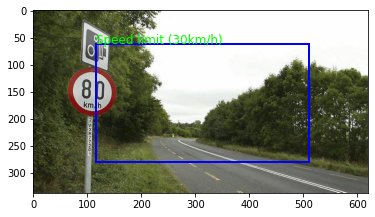

In [52]:
url = "https://www.independent.ie/regionals/enniscorthyguardian/news/2087b/29600327.ece/AUTOCROP/w620/NWS_20130917_New_008_28907846_I1.JPG"
predict_url(url)

In [53]:
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

image = Image.open("image_name.jpg")
image = image.convert("RGB")
image = image.resize(size=(32,32))
image = img_to_array(image)
image = np.array(image)
image = image.reshape(-1,32, 32, 3)
model.predict(image)

[array([[1.0548698e-11, 1.0000000e+00, 4.2532339e-11, 1.0000000e+00]],
       dtype=float32),
 array([[0.0000000e+00, 1.2202183e-19, 0.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)]

In [54]:
from keras.models import model_from_json


In [55]:
json_model = model.to_json()

In [56]:
with open('fashionmnist_model.json', 'w') as json_file:
    json_file.write(json_model)

In [57]:
%ls

'archive (2).zip'          Meta/
 BBox600EpochModel/        Meta.csv
 BBox600EpochModel.h5      ResNet-Traffic.pth
 cifar10-resnet9.pth       test/
 ClassificationModel.h5    Test/
 fashionmnist_model.json   Test.csv
 gfg.png                   traffic-keras.h5
 image.jpg                 _traffic-signs-in-germany_03748545_detail.jpg
 image_name.jpg            train/
 image.png                 Train/
 image_test_01.jpg         Train.csv
 meta/


Speed limit (30km/h)
[[2.5181558e-11 1.0000000e+00 2.0349882e-10 1.0000000e+00]]
8.058098632801602e-10
32.0
6.511962080679723e-09
32.0


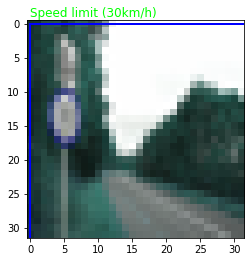

In [58]:
from numpy import asarray

image = cv2.imread("image_name.jpg")
image_fromarray = Image.fromarray(image, 'RGB')
resize_image = image_fromarray.resize((IMG_HEIGHT, IMG_WIDTH))
numpydata = asarray(resize_image)
new_array = cv2.resize(numpydata, (IMG_WIDTH, IMG_HEIGHT))
new_array = new_array.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)
pred = model.predict(new_array)
fig, ax = plt.subplots()
plt.imshow(numpydata, interpolation='nearest')

classes_x=np.argmax(pred[1],axis=1)
print(labels[int(classes_x)])
print(pred[0])
pred_x1 = pred[0][0][0] * IMG_WIDTH
pred_x2 = pred[0][0][1] * IMG_WIDTH
pred_y1 = pred[0][0][2] * IMG_HEIGHT
pred_y2 = pred[0][0][3] * IMG_HEIGHT

# pred_x1 = inverse_sigmoid(pred[0][0])
# pred_x2 = inverse_sigmoid(pred[0][1])
# pred_y1 = inverse_sigmoid(pred[0][2])
# pred_y2 = inverse_sigmoid(pred[0][3]) 

print(pred_x1)
print(pred_x2)
print(pred_y1)
print(pred_y2)
text = plt.text(pred_x1, pred_y1-1, labels[int(classes_x)], fontsize=12, color = 'lime')

rect = patches.Rectangle((pred_x1, pred_y1), pred_x2-pred_x1, pred_y2-pred_y1, linewidth=2, edgecolor='b', facecolor='none')
ax.add_patch(rect)
os.remove('image_name.jpg') # to save up space